# Import Library


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [ ]:
# Load the Excel file into a Pandas dataframe
df = pd.read_csv('traffy.csv')

# split coordinate column into separate latitude and longitude columns
df[['latitude', 'longitude']] = df['coords'].str.split(',', expand=True)

# drop the original coordinate column
df.drop('coords', axis=1, inplace=True)
df.head()

,type,organization,address,subdistrict,district,province,latitude,longitude
0,"{ถนน,PM2.5}",เขตราชเทวี,เพชรบุรี ถนนเพชรบุรี ราชเทวี กรุงเทพมหานคร : 8...,ถนนเพชรบุรี,ราชเทวี,กรุงเทพมหานคร,100.53522,13.75110
1,{ทางเท้า},เขตป้อมปราบศัตรูพ่าย,363/20 ถ. จักรวรรดิ แขวง บ้านบาตร เขตป้อมปราบศ...,บ้านบาตร,ป้อมปราบศัตรูพ่าย,กรุงเทพมหานคร,100.50696,13.74991
2,"{ถนน,เสียงรบกวน}",เขตบึงกุ่ม,37 หมู่บ้านเอกสิน 3 แขวงนวลจันทร์ เขตบึงกุ่ม ก...,นวลจันทร์,บึงกุ่ม,กรุงเทพมหานคร,100.64799,13.81476
3,"{ถนน,ร้องเรียน,สะพาน,สายไฟ}",เขตพระนคร,88 ถ. มหาไชย แขวงวังบูรพาภิรมย์ เขตพระนคร กรุง...,วังบูรพาภิรมย์,พระนคร,กรุงเทพมหานคร,100.50250,13.74551
4,"{ทางเท้า,ต้นไม้,ถนน,คลอง,ความสะอาด,ป้าย}",เขตวังทองหลาง,ลาดพร้าว 101 คลองจั่น บางกะปิ กรุงเทพมหานคร : ...,คลองเจ้าคุณสิงห์,วังทองหลาง,กรุงเทพมหานคร,100.62752,13.78410


In [ ]:
df['province'].value_counts()

กรุงเทพมหานคร           804
จังหวัดกรุงเทพมหานคร    193
สุราษฎร์ธานี              2
ปทุมธานี                  1
Name: province, dtype: int64

# Geospatial Visualize

In [ ]:
import folium

# number of locations
N = 100

# Create a map centered on a specific location
map = folium.Map(location=[13.7563, 100.5018], zoom_start=7)

# Loop through the rows of the dataframe and add a marker for each location
for index, row in df[:N].iterrows():
    lat = float(row['latitude'])
    lon = float(row['longitude'])
    folium.Marker([lon, lat]).add_to(map)

# map.save("Traffy.html")
map

# Clean Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          1000 non-null   object
 1   organization  999 non-null    object
 2   address       981 non-null    object
 3   subdistrict   1000 non-null   object
 4   district      1000 non-null   object
 5   province      1000 non-null   object
 6   latitude      1000 non-null   object
 7   longitude     1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [ ]:
df.dropna(subset=['organization', 'address'], inplace=True)
print(f"There are {df.shape[0]} rows left.")

There are 980 rows left.


In [ ]:
# number of missing values
null_counts = df.isnull().sum()
print(f"\nNumber of null values in each column after imputing:\n{null_counts}")


Number of null values in each column before imputing:
type            0
organization    0
address         0
subdistrict     0
district        0
province        0
latitude        0
longitude       0
dtype: int64


In [ ]:
# convert coord column to float
df = df.astype({"latitude": float, "longitude": float})

# K-Mean Clustering Model

<font color=red>Use __Calibrated DBSCAN__ for more accuracy</font>

In [ ]:
from sklearn.preprocessing import StandardScaler

selected = ['latitude', 'longitude']
df_describe = df[selected]

x = df_describe.values

# Standardize variables with Standard Scaler
scaler = StandardScaler()
scaler.fit(x)

cluster_data = scaler.fit_transform(x)
cluster_data

array([[-0.15296051, -0.09006689],
       [-0.46575135, -0.1086215 ],
       [ 1.09521439,  0.90252704],
       ...,
       [-1.4275887 , -0.70143365],
       [ 1.23921328, -0.6147415 ],
       [-0.4581142 , -0.13996165]])

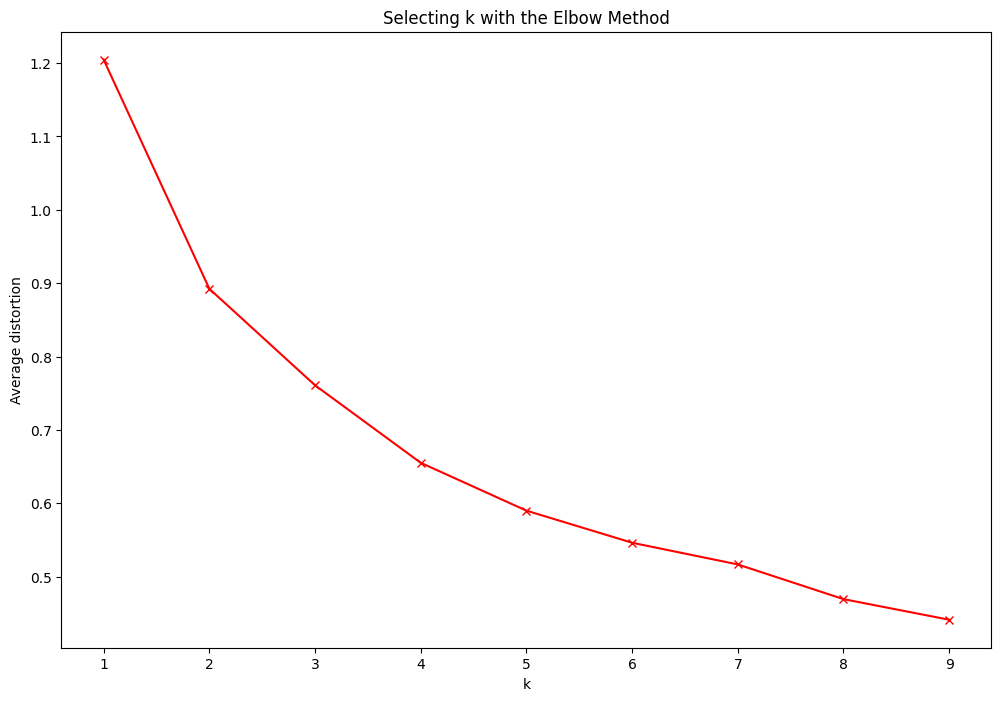

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Initialize the plot with the specified dimensions
fig = plt.figure(figsize=(12, 8))

# elbow method, to determine the optimal number of clusters
meandistortions = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=2020)
    kmeans.fit(cluster_data)
    summation = sum(np.min(cdist(cluster_data, kmeans.cluster_centers_, 'euclidean'), axis=1))
    meandistortions.append(summation / cluster_data.shape[0])

plt.plot(range(1, 10), meandistortions, 'rx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=2020)
kmeans.fit(cluster_data)

KMeans(n_clusters=2, random_state=2020)

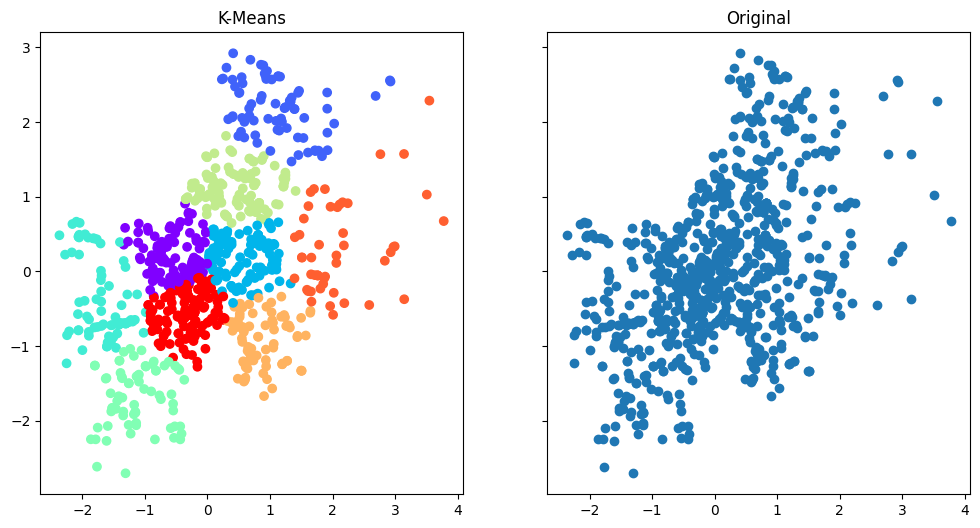

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('K-Means')
ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], c=kmeans.labels_, cmap='rainbow')

ax2.set_title("Original")
ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], cmap='rainbow')
plt.show()

## Show the centroid of each cluster

In [ ]:
# inverse transform to get original centroids back
original_data = scaler.inverse_transform(kmeans.cluster_centers_)

# get unique size for each clusters
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)

print(f"Normalize data:\n{'-' * 30}")
for idx, (x, y) in enumerate(kmeans.cluster_centers_):
    print(f"centroid {idx + 1} = ({x:5.2f}, {y:5.2f}), size = {counts[idx]}")

print(f"\nOriginal data:\n{'-' * 30}")
for idx, (x, y) in enumerate(original_data):
    print(f"centroid {idx + 1} = ({x:.2f}, {y:.2f})")

Normalize data:
------------------------------
centroid 1 = (-0.53,  0.17), size = 143
centroid 2 = ( 1.10,  2.18), size = 77
centroid 3 = ( 0.54,  0.18), size = 118
centroid 4 = (-1.64, -0.44), size = 95
centroid 5 = (-1.12, -1.67), size = 72
centroid 6 = ( 0.46,  1.09), size = 117
centroid 7 = ( 0.86, -0.92), size = 84
centroid 8 = ( 2.10,  0.32), size = 49
centroid 9 = (-0.29, -0.52), size = 225

Original data:
------------------------------
centroid 1 = (100.50, 13.77)
centroid 2 = (100.65, 13.90)
centroid 3 = (100.60, 13.77)
centroid 4 = (100.40, 13.73)
centroid 5 = (100.45, 13.65)
centroid 6 = (100.59, 13.83)
centroid 7 = (100.63, 13.70)
centroid 8 = (100.74, 13.78)
centroid 9 = (100.52, 13.72)


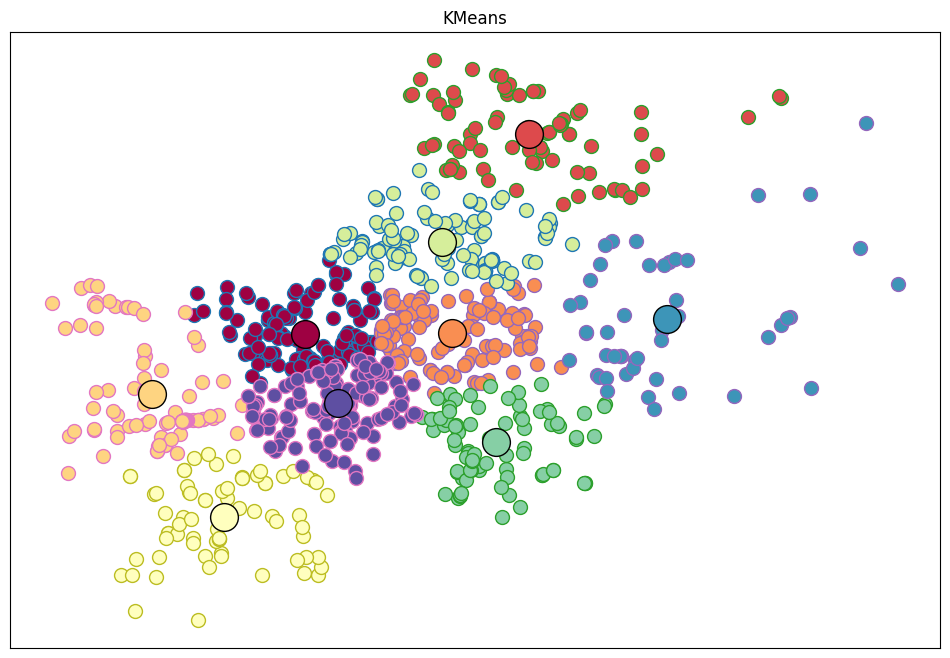

In [ ]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

# Colors uses a color map, which will produce an array of colors based on the
# number of labels there are. We use set(kmeans_labels) to get the unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(kmeans.labels_))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
for k, col in zip(range(len(kmeans.cluster_centers_)), colors):

    # Create a list of all data points, where the data points that are in the cluster 
    # (ex. cluster 0) are labeled as true, else they are labeled as false.
    my_members = (kmeans.labels_ == k)
    
    # Define the centroid, or cluster center.
    cluster_center = kmeans.cluster_centers_[k]
    
    # Plots the datapoints with color col.
    ax.plot(cluster_data[my_members, 0], cluster_data[my_members, 1], 'o', markerfacecolor=col, markersize=10)
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=20)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

# DBSCAN

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

<font color=red>TODO: add type distance?</font>

In [ ]:
from sklearn.metrics.pairwise import haversine_distances

# Handling Location
points_in_radians = df[['latitude', 'longitude']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances

# # Adding type
# added_km_per_type_gap = 1
# types = euclidean_distances(df[['type']].values) * added_km_per_type_gap 

In [ ]:
from sklearn.cluster import DBSCAN

# distance_matrix = rating_distances + distances_in_km
distance_matrix = distances_in_km

clustering = DBSCAN(metric='precomputed', eps=1, min_samples=3)
clustering.fit(distance_matrix)

DBSCAN(eps=1, metric='precomputed', min_samples=3)

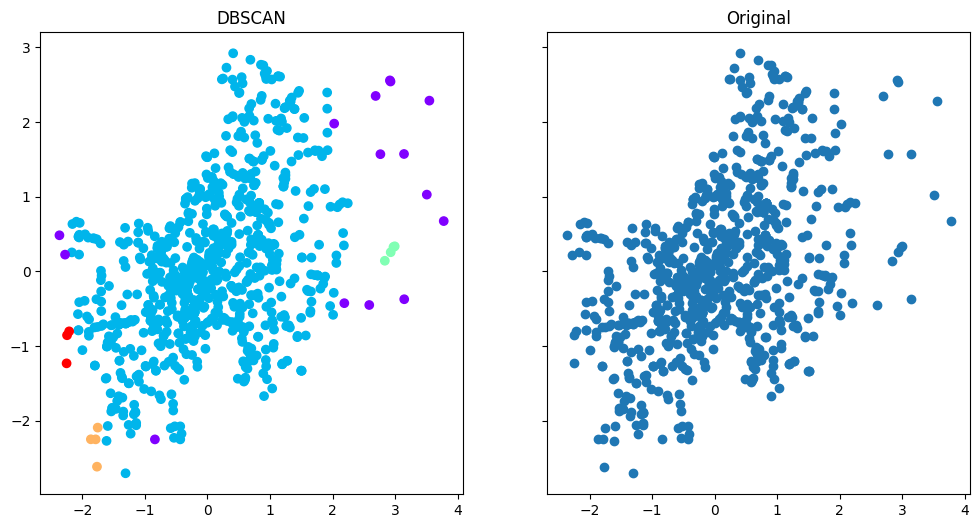

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

ax1.set_title('DBSCAN')
ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], c=clustering.labels_, cmap='rainbow')

ax2.set_title("Original")
ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], cmap='rainbow')
plt.show()